# Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_spike(t, t0, sigma, amplitude):
    """Gaussian spike, peak at t0 equals amplitude (amplitude >= 0)."""
    t = np.asarray(t, dtype=np.float32)
    z = (t - float(t0)) / float(sigma)
    return (float(amplitude) * np.exp(-0.5 * z * z)).astype(np.float32)

def sample_event_locations_uniform(L, n_events, rng, margin=0):
    low = int(margin)
    high = int(L - margin)
    if high <= low:
        raise ValueError("margin is too large for the given L")
    centers = rng.integers(low=low, high=high, size=int(n_events), endpoint=False)
    return np.sort(centers).astype(np.int32)

def sample_event_count_poisson(lam, rng, n_max=None, at_least_one=True):
    n = int(rng.poisson(lam=float(lam)))
    if at_least_one:
        n = max(1, n)
    if n_max is not None:
        n = min(n, int(n_max))
    return n

def sample_gpd_exceedance(n, sigma_gpd, xi, rng):
    """
    Sample y >= 0 from GPD exceedance distribution using inverse CDF.
    xi = 0 gives exponential tail.
    """
    n = int(n)
    sigma_gpd = float(sigma_gpd)
    xi = float(xi)
    if sigma_gpd <= 0.0:
        raise ValueError("sigma_gpd must be > 0")
    u = rng.uniform(0.0, 1.0, size=n).astype(np.float32)
    if abs(xi) < 1e-8:
        y = -sigma_gpd * np.log(1.0 - u)
    else:
        y = (sigma_gpd / xi) * ((1.0 - u) ** (-xi) - 1.0)
    return y.astype(np.float32)

def generate_toy_dataset_evt_strict_global_threshold(
    N,
    L,
    seed=0,
    # trend
    trend_a_range=(0.05, 0.1),
    trend_b_range=(-0.02, 0.02),
    # season
    season_bins=(5, 8, 11),
    season_A_range=(0.05, 0.1),
    phase_set=(0.0, np.pi/2, np.pi, 3*np.pi/2),
    # noise (smaller, and INCLUDED in baseline check)
    noise_std=0.01,
    # events
    lam_events=1.0,
    n_events_max=6,
    spike_sigma=2.5,
    # strict threshold control
    threshold_gap=0.01,       # make threshold > max(baseline+noise) by this gap
    cross_margin=0.02,        # ensure x_peak >= threshold + cross_margin (100% crossing)
    # optional extra tail randomness (still guaranteed to cross)
    add_gpd_tail=True,
    gpd_sigma=0.05,
    gpd_xi=0.20,
    # return
    return_components=False,
):
    """
    Two-phase toy generator with a SINGLE global threshold u_global such that:
      1) For all sequences/time, baseline_with_noise(t) = trend+season+noise is STRICTLY below u_global.
      2) After adding extreme, each sequence has >=1 event whose PEAK satisfies x(t0) >= u_global + cross_margin.

    Construction:
      - Phase A: generate trend+season+noise for all N, compute M = max_{i,t} baseline_with_noise.
               set u_global = M + threshold_gap  (=> 100% baseline does NOT exceed)
      - Phase B: generate extreme events. For each event center t0:
               amplitude_needed = max(0, (u_global + cross_margin) - baseline_with_noise[t0])
               amplitude = amplitude_needed + y (optional), y>=0
               x_peak(t0) = baseline_with_noise[t0] + amplitude >= u_global + cross_margin  (=> 100% crossing)

    Notes:
      - This guarantees peak crossing at event centers (not necessarily that the whole spike support is above threshold).
      - To guarantee EVERY sequence crosses, we force n_events >= 1.
    """
    rng = np.random.default_rng(seed)
    t = np.arange(L, dtype=np.float32)
    margin = int(np.ceil(3.0 * spike_sigma))

    # ---------- Phase A: generate baseline+noise first ----------
    trend_all = np.empty((N, L, 1), dtype=np.float32)
    season_all = np.empty((N, L, 1), dtype=np.float32)
    noise_all = np.empty((N, L, 1), dtype=np.float32)
    base_all  = np.empty((N, L, 1), dtype=np.float32)  # base = trend+season
    base_noise_all = np.empty((N, L, 1), dtype=np.float32)  # base+noise (used for strict threshold)

    max_base_noise = -np.inf
    for i in range(N):
        # trend
        a = rng.uniform(*trend_a_range)
        b0 = rng.uniform(*trend_b_range)
        trend = (b0 + a * (t / (L - 1))).astype(np.float32)

        # season
        season = np.zeros(L, dtype=np.float32)
        for k in season_bins:
            A = rng.uniform(*season_A_range)
            phi = float(rng.choice(np.asarray(phase_set, dtype=np.float32)))
            season += (A * np.sin(2.0 * np.pi * float(k) * t / float(L) + phi)).astype(np.float32)

        base = (trend + season).astype(np.float32)
        noise = rng.normal(0.0, noise_std, size=L).astype(np.float32)
        base_noise = (base + noise).astype(np.float32)

        trend_all[i, :, 0] = trend
        season_all[i, :, 0] = season
        base_all[i, :, 0] = base
        noise_all[i, :, 0] = noise
        base_noise_all[i, :, 0] = base_noise

        cur_max = float(np.max(base_noise))
        if cur_max > max_base_noise:
            max_base_noise = cur_max

    # global threshold: strictly above all baseline+noise values
    u_global = float(max_base_noise + float(threshold_gap))

    # ---------- Phase B: generate extreme so every sequence crosses ----------
    extreme_all = np.zeros((N, L, 1), dtype=np.float32)
    X = np.empty((N, L, 1), dtype=np.float32)

    for i in range(N):
        base_noise = base_noise_all[i, :, 0]  # (L,)

        n_events = sample_event_count_poisson(lam_events, rng, n_max=n_events_max, at_least_one=True)
        centers = sample_event_locations_uniform(L, n_events, rng, margin=margin)

        # optional tail
        if add_gpd_tail:
            y = sample_gpd_exceedance(n_events, gpd_sigma, gpd_xi, rng)
        else:
            y = np.zeros((n_events,), dtype=np.float32)

        extreme = np.zeros(L, dtype=np.float32)
        for j, t0 in enumerate(centers):
            needed = (u_global + float(cross_margin)) - float(base_noise[int(t0)])
            amp_needed = max(0.0, needed)
            amp = float(amp_needed) + float(y[j])  # still guaranteed >= amp_needed
            extreme += gaussian_spike(t, int(t0), spike_sigma, amp)

        extreme_all[i, :, 0] = extreme
        X[i, :, 0] = (base_noise + extreme).astype(np.float32)

    # ---------- (Optional) strict sanity checks ----------
    # 1) baseline+noise never exceeds threshold
    if not (np.max(base_noise_all) < u_global):
        raise RuntimeError("Sanity check failed: baseline+noise exceeded u_global. Increase threshold_gap.")
    # 2) every sequence crosses threshold after adding extreme (at least somewhere)
    if not np.all(np.max(X[:, :, 0], axis=1) >= (u_global + float(cross_margin) - 1e-7)):
        raise RuntimeError("Sanity check failed: some sequences did not cross threshold. Increase cross_margin or ensure events exist.")

    if return_components:
        comps = {
            "trend": trend_all,
            "season": season_all,
            "base": base_all,                 # trend+season
            "noise": noise_all,
            "baseline_with_noise": base_noise_all,  # trend+season+noise
            "extreme": extreme_all,
            "u_global": u_global,
            "threshold_gap": float(threshold_gap),
            "cross_margin": float(cross_margin),
        }
        return X, comps

    return X, u_global

In [2]:
N, L = 10000, 200
X, comps = generate_toy_dataset_evt_strict_global_threshold(
    N=N, L=L, seed=0,
    noise_std=0.01,        # smaller noise
    threshold_gap=0.01,  
    lam_events = 2,# baseline strictly under threshold
    n_events_max=8,
    cross_margin=0.02,     # extreme peak strictly above threshold
    return_components=True
)

## Toy Visualization

In [3]:
def plot_toy_and_components(
    X,
    comps=None,
    random_state=None,
    num=5,
    show_threshold_in=("X", "base"),
    q_label=None,
    # NEW: unified threshold
    u_global=None,
    thr_name="u_global",
):
    """
    Plot random samples of X and optionally components, with either:
      (a) per-sample thresholds comps["u_abs"] (shape (N,)), or
      (b) a single unified threshold u_global (scalar), or both.

    If both are provided, draws BOTH lines (u_global solid, u_abs dashed).
    """
    N, T, C = X.shape
    rng = np.random.default_rng() if random_state is None else np.random.default_rng(random_state)
    num = min(int(num), N)
    idx = rng.choice(N, size=num, replace=False)
    x = np.arange(T)

    # --- per-sample threshold (optional) ---
    u_abs = None
    if comps is not None and "u_abs" in comps:
        u_abs = np.asarray(comps["u_abs"]).reshape(-1)
        if u_abs.shape[0] != N:
            raise ValueError(f"comps['u_abs'] must have length N={N}, got {u_abs.shape[0]}")
        if q_label is None and "base_quantile" in comps:
            q_label = f"q={comps['base_quantile']}"
    u_abs_label = "u_abs" + (f" ({q_label})" if q_label else "")

    # --- unified threshold (optional) ---
    if u_global is None and comps is not None:
        # allow passing unified threshold through comps, e.g. comps["u_global"]
        if "u_global" in comps:
            u_global = float(comps["u_global"])

    def _draw_thresholds(i):
        """Draw thresholds (if available)."""
        # unified threshold: solid
        if u_global is not None:
            plt.axhline(float(u_global), linestyle="-", linewidth=1.2, alpha=0.9, color="k")
        # per-sample threshold: dashed
        if u_abs is not None:
            plt.axhline(float(u_abs[i]), linestyle="--", linewidth=1.2, alpha=0.9, color="k")

    def _add_threshold_legend_handles():
        """Add one legend entry for thresholds (avoid duplicated labels)."""
        handles, labels = plt.gca().get_legend_handles_labels()

        # Add dummy handles for threshold legend entries if they exist
        if u_global is not None and (thr_name not in labels):
            h = plt.Line2D([0], [0], color="k", lw=1.2, linestyle="-")
            handles.append(h)
            labels.append(thr_name)

        if u_abs is not None and (u_abs_label not in labels):
            h = plt.Line2D([0], [0], color="k", lw=1.2, linestyle="--")
            handles.append(h)
            labels.append(u_abs_label)

        plt.legend(handles, labels)

    # ---------- Plot X ----------
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(x, X[i, :, 0], alpha=0.9, label=f"idx={i}")
        if "X" in show_threshold_in:
            _draw_thresholds(i)
    plt.title(f"Random {num} samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    _add_threshold_legend_handles()
    plt.tight_layout()
    plt.show()

    if comps is None:
        return

    trend = comps["trend"]
    season = comps["season"]
    extreme = comps["extreme"]
    base = comps.get("base", None)
    base_noise = comps.get("baseline_with_noise", None)  # optional

    # ---------- Plot Trend ----------
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, trend[i, :, 0], alpha=0.9, label=f"idx={i}")
        if "trend" in show_threshold_in:
            _draw_thresholds(i)
    plt.title(f"Trend (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    _add_threshold_legend_handles()
    plt.tight_layout()
    plt.show()

    # ---------- Plot Seasonality ----------
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, season[i, :, 0], alpha=0.9, label=f"idx={i}")
        if "season" in show_threshold_in:
            _draw_thresholds(i)
    plt.title(f"Seasonality (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    _add_threshold_legend_handles()
    plt.tight_layout()
    plt.show()

    # ---------- Plot Base ----------
    if base is not None:
        plt.figure(figsize=(10, 3.2))
        for i in idx:
            plt.plot(x, base[i, :, 0], alpha=0.9, label=f"idx={i}")
            if "base" in show_threshold_in:
                _draw_thresholds(i)
        plt.title(f"Baseline = Trend + Seasonality (random {num} samples)")
        plt.xlabel("Time index")
        plt.ylabel("Value")
        _add_threshold_legend_handles()
        plt.tight_layout()
        plt.show()

    # ---------- Plot Baseline+Noise (optional, very useful for strict-global-threshold toy) ----------
    if base_noise is not None:
        plt.figure(figsize=(10, 3.2))
        for i in idx:
            plt.plot(x, base_noise[i, :, 0], alpha=0.9, label=f"idx={i}")
            if "baseline_with_noise" in show_threshold_in:
                _draw_thresholds(i)
        plt.title(f"Baseline + Noise (random {num} samples)")
        plt.xlabel("Time index")
        plt.ylabel("Value")
        _add_threshold_legend_handles()
        plt.tight_layout()
        plt.show()

    # ---------- Plot Extreme ----------
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, extreme[i, :, 0], alpha=0.9, label=f"idx={i}")
        if "extreme" in show_threshold_in:
            _draw_thresholds(i)
    plt.title(f"Extreme (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    _add_threshold_legend_handles()
    plt.tight_layout()
    plt.show()

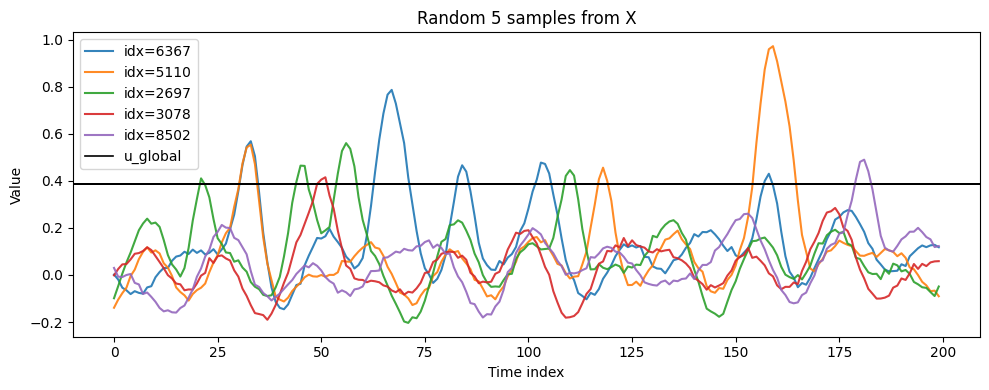

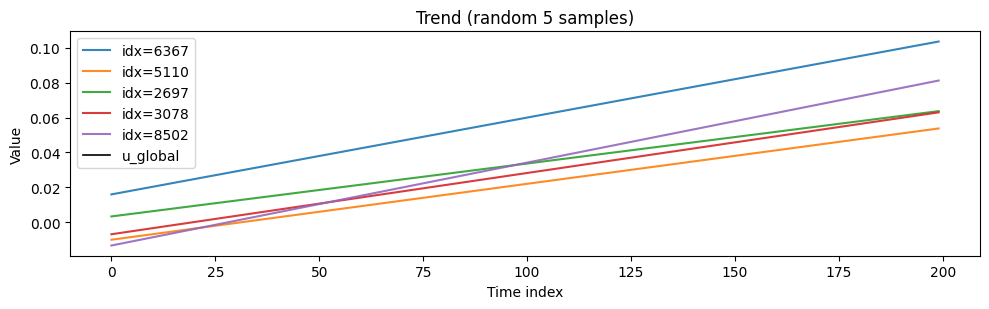

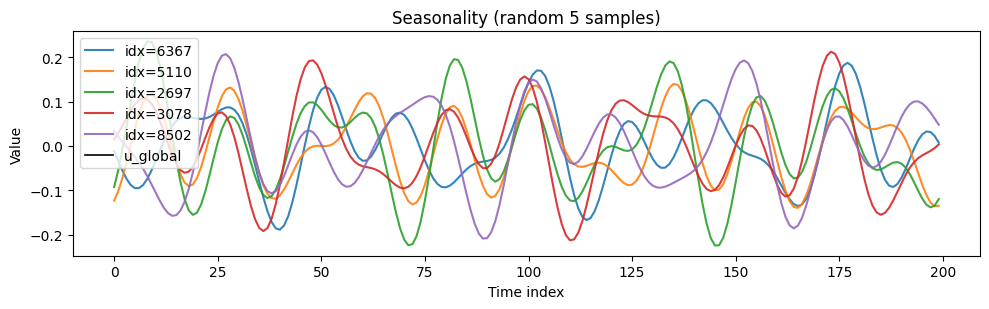

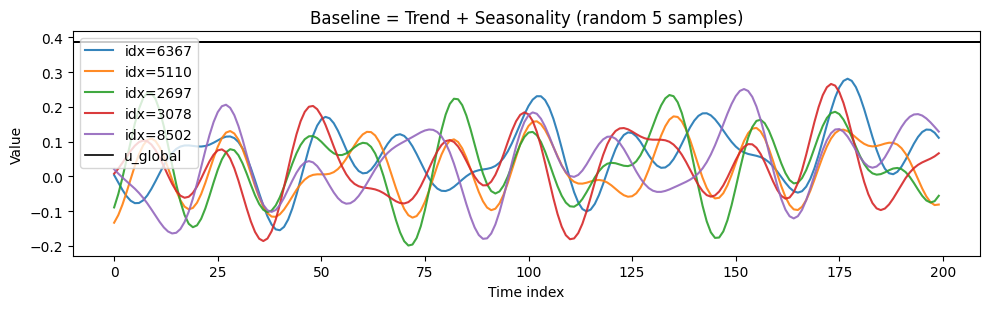

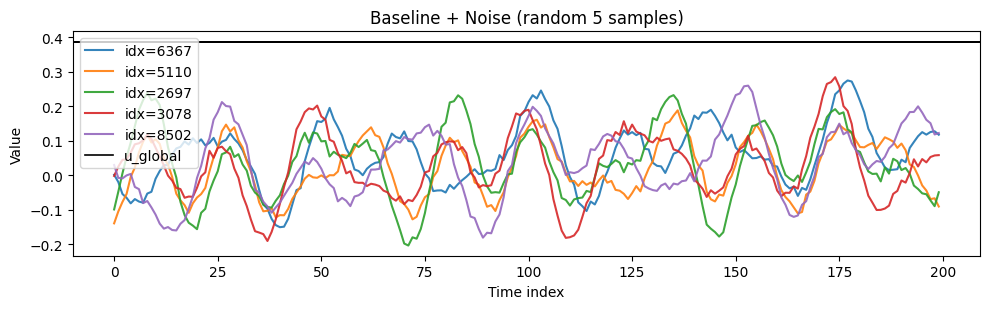

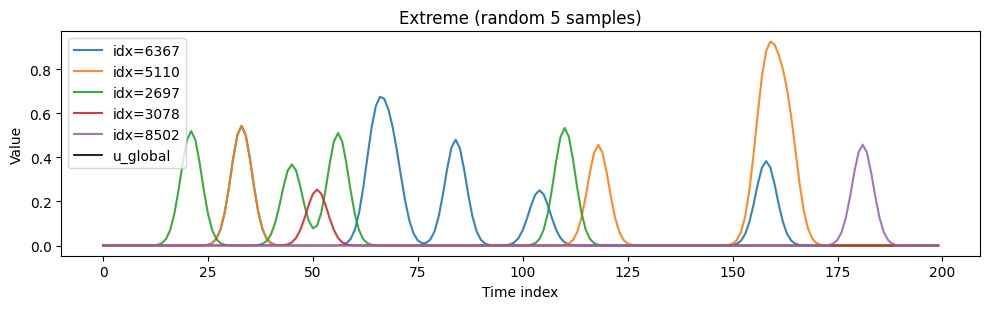

In [4]:
plot_toy_and_components(
    X, comps=comps,
    random_state=0, num=5,
    show_threshold_in=("X", "baseline_with_noise", "base")
)

## Extreme Consistent Check

In [5]:
def _find_peaks_1d(y, eps=1e-6, min_distance=3):
    """
    Very small peak-finder for 1D numpy array (no scipy).
    Peaks: y[i] > y[i-1] and y[i] >= y[i+1] and y[i] > eps
    Then apply simple non-maximum suppression with min_distance.
    """
    y = np.asarray(y, dtype=np.float32)
    T = y.shape[0]
    if T < 3:
        return np.array([], dtype=np.int32)

    # raw peaks
    mid = y[1:-1]
    left = y[:-2]
    right = y[2:]
    raw = np.where((mid > left) & (mid >= right) & (mid > eps))[0] + 1  # shift by 1

    if raw.size == 0:
        return np.array([], dtype=np.int32)

    # sort by peak height desc
    raw = raw[np.argsort(y[raw])[::-1]]

    # NMS: keep peaks separated by min_distance
    kept = []
    for p in raw:
        if all(abs(p - q) > min_distance for q in kept):
            kept.append(int(p))
    kept = np.array(sorted(kept), dtype=np.int32)
    return kept

def check_extreme_peaks_exceed_baseline(
    X,
    comps,
    baseline_key="baseline_with_noise",  # or "base" (then we will add noise if provided)
    extreme_key="extreme",
    mode="global_max",   # "local" or "global_max"
    margin=0.0,          # require X_peak >= baseline + margin
    peak_eps=1e-6,       # ignore tiny extreme values
    min_peak_distance=3, # merge nearby peaks from same gaussian spike
    require_at_least_one_peak=True,
    verbose=True,
):
    """
    Check: for EACH detected extreme event peak, does it exceed baseline?

    - baseline(t): usually comps["baseline_with_noise"] = trend+season+noise (recommended)
                  If not present, you can pass baseline_key="base" and provide comps["noise"].
    - extreme(t): comps["extreme"] (positive spikes)
    - Detect event centers by peak-finding on extreme(t).
    - For each peak index p:
        local mode:     X[p] >= baseline[p] + margin
        global_max mode:X[p] >= max_t baseline[t] + margin   (stronger, makes “global exceed”)

    Returns
    -------
    report : dict
      {
        "all_pass": bool,
        "per_seq_pass": (N,) bool,
        "num_peaks": (N,) int,
        "failed_indices": list[int],
        "details": list[dict]  # per failing sequence info
      }
    """
    X = np.asarray(X, dtype=np.float32)
    N, T, C = X.shape
    if C != 1:
        raise ValueError("This checker assumes X shape (N, T, 1).")

    # baseline
    if baseline_key in comps:
        baseline = np.asarray(comps[baseline_key], dtype=np.float32)
    else:
        raise KeyError(f"comps missing baseline_key='{baseline_key}'")
    if baseline.shape != X.shape:
        raise ValueError(f"baseline shape {baseline.shape} must match X shape {X.shape}")

    # extreme
    if extreme_key not in comps:
        raise KeyError(f"comps missing extreme_key='{extreme_key}'")
    extreme = np.asarray(comps[extreme_key], dtype=np.float32)
    if extreme.shape != X.shape:
        raise ValueError(f"extreme shape {extreme.shape} must match X shape {X.shape}")

    per_seq_pass = np.ones((N,), dtype=bool)
    num_peaks = np.zeros((N,), dtype=np.int32)
    failed = []
    details = []

    for i in range(N):
        b = baseline[i, :, 0]
        e = extreme[i, :, 0]
        x = X[i, :, 0]

        peaks = _find_peaks_1d(e, eps=peak_eps, min_distance=min_peak_distance)
        num_peaks[i] = int(peaks.size)

        if require_at_least_one_peak and peaks.size == 0:
            per_seq_pass[i] = False
            failed.append(i)
            details.append({
                "idx": i,
                "reason": "no_extreme_peak_detected",
                "max_baseline": float(np.max(b)),
                "max_extreme": float(np.max(e)),
                "max_X": float(np.max(x)),
            })
            continue

        b_max = float(np.max(b))
        bad_peaks = []
        for p in peaks:
            if mode == "local":
                rhs = float(b[p]) + float(margin)
            elif mode == "global_max":
                rhs = b_max + float(margin)
            else:
                raise ValueError("mode must be 'local' or 'global_max'")

            if float(x[p]) < rhs:
                bad_peaks.append({
                    "t": int(p),
                    "X_at_peak": float(x[p]),
                    "baseline_at_t": float(b[p]),
                    "baseline_max": b_max,
                    "extreme_at_t": float(e[p]),
                    "required_rhs": rhs,
                    "gap": float(x[p] - rhs),
                })

        if len(bad_peaks) > 0:
            per_seq_pass[i] = False
            failed.append(i)
            details.append({
                "idx": i,
                "reason": "some_peaks_not_exceeding_baseline",
                "mode": mode,
                "margin": float(margin),
                "num_detected_peaks": int(peaks.size),
                "bad_peaks": bad_peaks,
                "max_baseline": b_max,
                "max_extreme": float(np.max(e)),
                "max_X": float(np.max(x)),
            })

    all_pass = bool(np.all(per_seq_pass))

    report = {
        "all_pass": all_pass,
        "per_seq_pass": per_seq_pass,
        "num_peaks": num_peaks,
        "failed_indices": failed,
        "details": details,
    }

    if verbose:
        print(f"[check] mode={mode}, margin={margin}, peak_eps={peak_eps}, min_peak_distance={min_peak_distance}")
        print(f"[check] pass: {int(per_seq_pass.sum())}/{N}, all_pass={all_pass}")
        if failed:
            print(f"[check] first few failed idx: {failed[:10]}")
            # print one example failure succinctly
            ex = details[0]
            print(f"[check] example failure idx={ex['idx']} reason={ex['reason']}")
            if ex["reason"] == "some_peaks_not_exceeding_baseline":
                bp = ex["bad_peaks"][0]
                print(f"        at t={bp['t']}: X={bp['X_at_peak']:.4f}, required>={bp['required_rhs']:.4f}, gap={bp['gap']:.4f}")
    return report


In [6]:
report = check_extreme_peaks_exceed_baseline(
    X, comps,
    baseline_key="baseline_with_noise",
    mode="global_max",
    margin=0.02,          
    peak_eps=1e-6,
    min_peak_distance=3,
    require_at_least_one_peak=True,
)

[check] mode=global_max, margin=0.02, peak_eps=1e-06, min_peak_distance=3
[check] pass: 10000/10000, all_pass=True


# Extreme Visualization

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def extract_extreme_events_global_threshold(
    X,
    u_global: float,
    strict_greater: bool = True,   # True: x>u, False: x>=u
    min_width: int = 1,            # 过滤太短的段
    merge_gap: int = 0,            # 允许把间隔<=merge_gap的两个段合并（可选）
):
    """
    Detect extreme events by a single global threshold u_global.

    Event definition:
      - a contiguous segment where x(t) > u_global (or >=)
      - one event -> one peak: the highest point inside the segment

    Returns
    -------
    events : list[dict]
        Each dict describes one event with fields:
        - seq_idx, event_id
        - l, r, width
        - peak_t, peak_value
        - exceedance = peak_value - u_global
        - area = sum(max(0, x-u_global)) over [l,r]
        - energy = sum(max(0, x-u_global)^2) over [l,r]
    counts : (N,) int array
        number of events per sequence
    """
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 3 or X.shape[2] != 1:
        raise ValueError(f"X must have shape (N, T, 1), got {X.shape}")
    N, T, _ = X.shape
    u = float(u_global)

    def _segments_from_mask(mask_1d: np.ndarray):
        """Return list of (l,r) inclusive segments where mask is True."""
        idx = np.flatnonzero(mask_1d)
        if idx.size == 0:
            return []

        # group consecutive indices
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[breaks + 1]]
        ends   = np.r_[idx[breaks], idx[-1]]
        segs = [(int(l), int(r)) for l, r in zip(starts, ends)]

        # optional merge if close
        if merge_gap > 0 and len(segs) >= 2:
            merged = [segs[0]]
            for l, r in segs[1:]:
                prev_l, prev_r = merged[-1]
                if l - prev_r - 1 <= merge_gap:
                    merged[-1] = (prev_l, r)  # merge
                else:
                    merged.append((l, r))
            segs = merged

        # filter by min_width
        segs = [(l, r) for (l, r) in segs if (r - l + 1) >= int(min_width)]
        return segs

    events = []
    counts = np.zeros((N,), dtype=np.int32)

    for i in range(N):
        x = X[i, :, 0]
        mask = (x > u) if strict_greater else (x >= u)
        segs = _segments_from_mask(mask)

        counts[i] = len(segs)
        for eid, (l, r) in enumerate(segs):
            seg = x[l:r+1]
            # peak inside segment (one event -> one peak)
            rel = int(np.argmax(seg))
            peak_t = l + rel
            peak_val = float(seg[rel])

            exceed = peak_val - u
            over = np.maximum(0.0, seg - u).astype(np.float32)
            area = float(np.sum(over))
            energy = float(np.sum(over * over))

            events.append({
                "seq_idx": int(i),
                "event_id": int(eid),
                "l": int(l),
                "r": int(r),
                "width": int(r - l + 1),
                "peak_t": int(peak_t),
                "peak_value": peak_val,
                "exceedance": float(exceed),
                "area": area,
                "energy": energy,
            })

    return events, counts

def summarize_and_plot_extreme_events_with_fits(
    events,
    counts,
    L: int,
    u_global: float,
    show_plots: bool = True,
    # histogram bins
    bins_time: int = 30,
    bins_val: int = 30,
    bins_width: int = 30,
    # fit options
    fit_distributions: bool = True,     # True: overlay fitted pdf on last 3 plots
    width_model: str = "lognormal",     # "lognormal" or "gamma"
    density_hist: bool = True,          # True to overlay pdf (must be density)
):
    """
    One unified function:
      - prints dataset-level summary (same as summarize_extreme_events)
      - visualizes 4 plots:
          1) peak_t histogram (count)
          2) peak_value histogram (+ shifted GPD pdf)
          3) exceedance histogram (+ GPD pdf)
          4) width histogram (+ Lognormal or Gamma pdf)

    Notes:
      - PDF overlays require SciPy. If SciPy is missing and fit_distributions=True,
        we will raise an ImportError.
      - For pdf overlays, hist is plotted with density=True (recommended).
    """
    N = int(len(counts))
    u = float(u_global)

    print(f"[threshold] u_global = {u:.6f}")
    print(f"[events] sequences N={N}, length L={int(L)}")
    print(f"[events] total events = {int(np.sum(counts))}")
    print(f"[events] event count per sequence: mean={counts.mean():.3f}, "
          f"p50={np.median(counts):.1f}, max={counts.max()}")

    if len(events) == 0:
        print("[events] no events detected.")
        return None

    # arrays
    peak_t = np.array([e["peak_t"] for e in events], dtype=np.int32)
    peak_v = np.array([e["peak_value"] for e in events], dtype=np.float64)
    width  = np.array([e["width"] for e in events], dtype=np.float64)
    exceed = np.array([e["exceedance"] for e in events], dtype=np.float64)
    area   = np.array([e["area"] for e in events], dtype=np.float64)
    energy = np.array([e["energy"] for e in events], dtype=np.float64)

    def _q(arr):
        arr = np.asarray(arr, dtype=np.float64)
        return {
            "mean": float(np.mean(arr)),
            "p50": float(np.quantile(arr, 0.50)),
            "p90": float(np.quantile(arr, 0.90)),
            "p95": float(np.quantile(arr, 0.95)),
            "max": float(np.max(arr)),
        }

    print("[peak_t]", _q(peak_t.astype(np.float64)))
    print("[peak_value]", _q(peak_v))
    print("[exceedance=peak-u]", _q(exceed))
    print("[width]", _q(width))
    print("[area]", _q(area))
    print("[energy]", _q(energy))

    # ----- optional fitting (SciPy) -----
    fit_params = {}
    if fit_distributions:
        try:
            from scipy.stats import genpareto, lognorm, gamma as gamma_dist
        except Exception as e:
            raise ImportError("SciPy not found. Please install scipy to fit/plot PDFs.") from e

        # Fit GPD on exceedance (loc fixed 0)
        exc = exceed[exceed > 1e-12]
        xi, _, sigma = genpareto.fit(exc, floc=0.0)
        fit_params["gpd_exceedance"] = {"xi": float(xi), "sigma": float(sigma), "loc": 0.0}
        fit_params["gpd_peak_value"] = {"xi": float(xi), "sigma": float(sigma), "loc": float(u)}

        # Fit width distribution
        w = width[width > 0]
        if width_model.lower() == "lognormal":
            s, _, scale = lognorm.fit(w, floc=0.0)
            mu = float(np.log(scale))
            fit_params["width_lognormal"] = {"mu": mu, "s": float(s), "loc": 0.0}
        elif width_model.lower() == "gamma":
            k, _, theta = gamma_dist.fit(w, floc=0.0)  # k=shape, theta=scale
            fit_params["width_gamma"] = {"k": float(k), "theta": float(theta), "loc": 0.0}
        else:
            raise ValueError("width_model must be 'lognormal' or 'gamma'.")

    # ----- visualization -----
    if show_plots:
        # helper for hist + pdf overlay
        def _hist_with_pdf(data, bins, title, xlabel, pdf_fn=None, pdf_label=None):
            data = np.asarray(data, dtype=np.float64)
            data = data[np.isfinite(data)]
            plt.figure(figsize=(10, 3.6))

            if pdf_fn is None:
                # count histogram
                plt.hist(data, bins=bins)
                plt.ylabel("count")
            else:
                # density histogram for pdf overlay
                plt.hist(data, bins=bins, density=True, alpha=0.7, label="hist (density)")
                grid = np.linspace(data.min(), data.max(), 600)
                pdf = pdf_fn(grid)
                plt.plot(grid, pdf, linewidth=2.0, label=pdf_label if pdf_label else "fitted pdf")
                plt.ylabel("density")
                plt.legend()

            plt.title(title)
            plt.xlabel(xlabel)
            plt.tight_layout()
            plt.show()

        # 1) peak_t (no parametric fit)
        _hist_with_pdf(
            peak_t,
            bins=min(int(L), bins_time),
            title="Peak location distribution (peak_t)",
            xlabel="time index",
            pdf_fn=None,
        )

        # 2) peak_value + shifted GPD pdf
        if fit_distributions:
            from scipy.stats import genpareto
            xi = fit_params["gpd_peak_value"]["xi"]
            sigma = fit_params["gpd_peak_value"]["sigma"]
            loc = fit_params["gpd_peak_value"]["loc"]
            _hist_with_pdf(
                peak_v,
                bins=bins_val,
                title=f"Peak value distribution + shifted GPD (loc={loc:.3f}, xi={xi:.3f}, sigma={sigma:.3f})",
                xlabel="peak_value",
                pdf_fn=lambda z: genpareto.pdf(z, c=xi, loc=loc, scale=sigma),
                pdf_label="shifted GPD pdf",
            )
        else:
            _hist_with_pdf(peak_v, bins=bins_val, title="Peak value distribution (peak_value)", xlabel="peak_value")

        # 3) exceedance + GPD pdf
        if fit_distributions:
            from scipy.stats import genpareto
            xi = fit_params["gpd_exceedance"]["xi"]
            sigma = fit_params["gpd_exceedance"]["sigma"]
            _hist_with_pdf(
                exceed[exceed > 1e-12],
                bins=bins_val,
                title=f"Exceedance distribution + GPD (xi={xi:.3f}, sigma={sigma:.3f})",
                xlabel="exceedance = peak_value - u_global",
                pdf_fn=lambda z: genpareto.pdf(z, c=xi, loc=0.0, scale=sigma),
                pdf_label="GPD pdf",
            )
        else:
            _hist_with_pdf(exceed, bins=bins_val, title="Exceedance distribution", xlabel="exceedance")

        # 4) width + (lognormal/gamma) pdf
        if fit_distributions:
            w = width[width > 0].astype(int)
        
            # integer-aligned bin edges: each integer gets its own bin [k-0.5, k+0.5)
            w_min, w_max = int(w.min()), int(w.max())
            edges = np.arange(w_min - 0.5, w_max + 1.5, 1.0)
        
            # plot density hist (needed for pdf overlay)
            plt.figure(figsize=(10, 3.6))
            plt.hist(
                w,
                bins=edges,
                density=True,
                alpha=0.7,
                rwidth=0.9,
                label="hist (density)"
            )
        
            # overlay pdf
            grid = np.linspace(w_min, w_max, 600)
        
            if width_model.lower() == "lognormal":
                from scipy.stats import lognorm
                mu = fit_params["width_lognormal"]["mu"]
                s = fit_params["width_lognormal"]["s"]
                pdf = lognorm.pdf(grid, s=s, loc=0.0, scale=np.exp(mu))
                plt.plot(grid, pdf, linewidth=2.0, label="Lognormal pdf")
                plt.title(f"Event span (width) + Lognormal (mu={mu:.3f}, s={s:.3f})")
        
            else:
                from scipy.stats import gamma as gamma_dist
                k = fit_params["width_gamma"]["k"]
                theta = fit_params["width_gamma"]["theta"]
                pdf = gamma_dist.pdf(grid, a=k, loc=0.0, scale=theta)
                plt.plot(grid, pdf, linewidth=2.0, label="Gamma pdf")
                plt.title(f"Event span (width) + Gamma (k={k:.3f}, theta={theta:.3f})")
        
            # nicer integer ticks (avoid overcrowding)
            if (w_max - w_min + 1) <= 30:
                plt.xticks(np.arange(w_min, w_max + 1, 1))
            else:
                step = int(np.ceil((w_max - w_min + 1) / 30))
                plt.xticks(np.arange(w_min, w_max + 1, step))
        
            plt.xlabel("width (r-l+1)")
            plt.ylabel("density")
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            # even without fitting, still use integer-aligned bins (count histogram)
            w = width[width > 0].astype(int)
            w_min, w_max = int(w.min()), int(w.max())
            edges = np.arange(w_min - 0.5, w_max + 1.5, 1.0)
        
            plt.figure(figsize=(10, 3.6))
            plt.hist(w, bins=edges, density=False, alpha=0.7, rwidth=0.9)
            if (w_max - w_min + 1) <= 30:
                plt.xticks(np.arange(w_min, w_max + 1, 1))
            else:
                step = int(np.ceil((w_max - w_min + 1) / 30))
                plt.xticks(np.arange(w_min, w_max + 1, step))
            plt.title("Event span distribution (width)")
            plt.xlabel("width (r-l+1)")
            plt.ylabel("count")
            plt.tight_layout()
            plt.show()

    return {
        "peak_t": peak_t.astype(np.int32),
        "peak_value": peak_v.astype(np.float32),
        "exceedance": exceed.astype(np.float32),
        "width": width.astype(np.int32),
        "area": area.astype(np.float32),
        "energy": energy.astype(np.float32),
        "counts": counts,
        "fit_params": fit_params,
    }


[threshold] u_global = 0.388080
[events] sequences N=10000, length L=200
[events] total events = 20071
[events] event count per sequence: mean=2.007, p50=2.0, max=7
[peak_t] {'mean': 99.72412934084002, 'p50': 100.0, 'p90': 173.0, 'p95': 182.0, 'max': 192.0}
[peak_value] {'mean': 0.4914839528009179, 'p50': 0.45405876636505127, 'p90': 0.6053338050842285, 'p95': 0.7197396457195282, 'max': 2.485323190689087}
[exceedance=peak-u] {'mean': 0.10340364436357048, 'p50': 0.06597845792770385, 'p90': 0.2172534966468811, 'p95': 0.3316593372821808, 'max': 2.0972428822517397}
[width] {'mean': 3.490209755368442, 'p50': 3.0, 'p90': 6.0, 'p95': 7.0, 'max': 18.0}
[area] {'mean': 0.32298316180210085, 'p50': 0.1363905370235443, 'p90': 0.7880163192749023, 'p95': 1.404950737953186, 'max': 11.379596710205078}
[energy] {'mean': 0.0714759160731556, 'p50': 0.007344536483287811, 'p90': 0.1324748396873474, 'p95': 0.35157836973667145, 'max': 17.672609329223633}


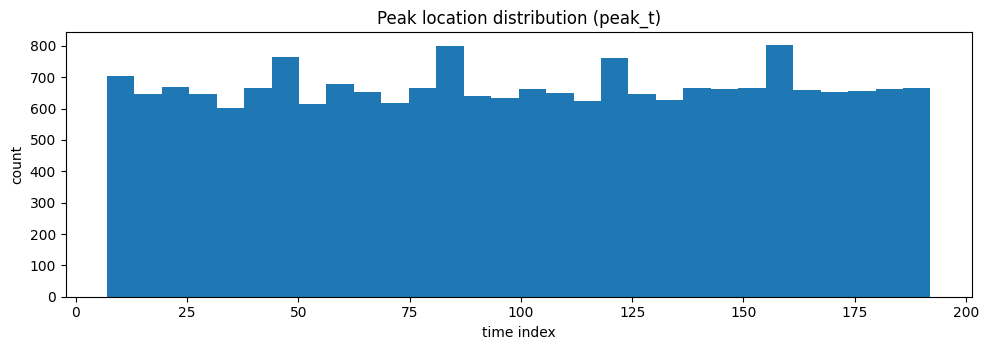

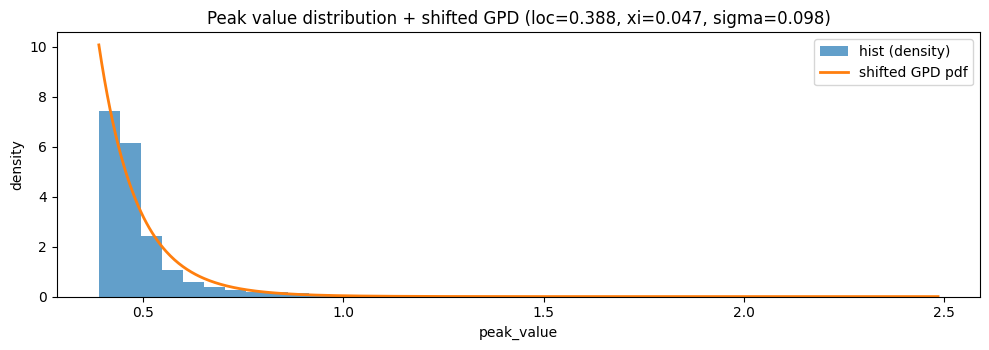

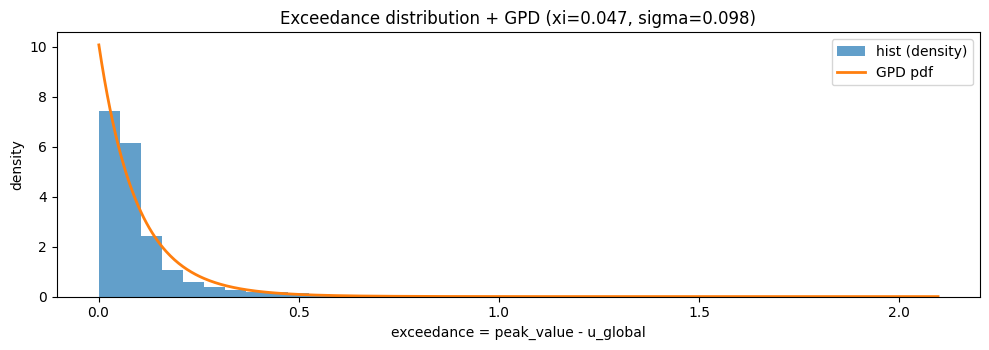

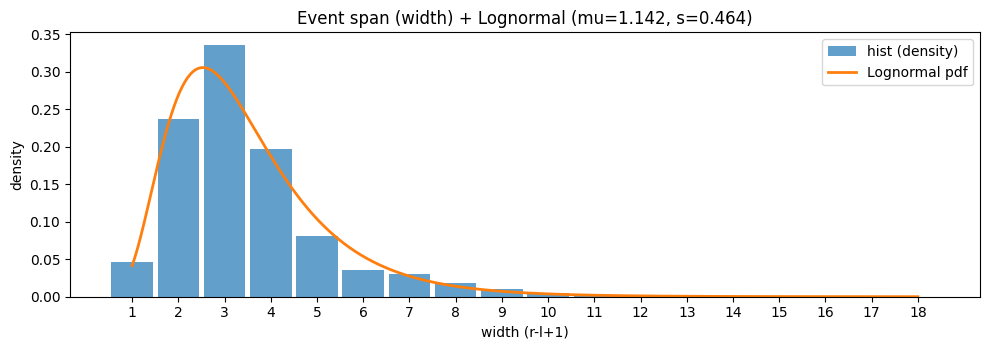

{'gpd_exceedance': {'xi': 0.04675900036898956, 'sigma': 0.09849101484587085, 'loc': 0.0}, 'gpd_peak_value': {'xi': 0.04675900036898956, 'sigma': 0.09849101484587085, 'loc': 0.3880803084373474}, 'width_lognormal': {'mu': 1.1424671037818848, 's': 0.4637407718600652, 'loc': 0.0}}


In [8]:
u_global = comps['u_global']

events, counts = extract_extreme_events_global_threshold(X, u_global=u_global, merge_gap=0, min_width=1)

out = summarize_and_plot_extreme_events_with_fits(
    events, counts,
    L=X.shape[1],
    u_global=u_global,
    show_plots=True,
    bins_time=30,
    bins_val=40,
    bins_width=30,
    fit_distributions=True,     # 叠加分布曲线
    width_model="lognormal",    # 或 "gamma"
)
print(out["fit_params"])        # 打印拟合参数

In [9]:
X1 = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X1)